The size of daily rainfall events is a relevant variable in agronomy, hydrology, and forestry. Small rainfall events are often intercepted by plant canopies and litter on the soil surface, so they are not very effective for increasing soil moisture.

In this tutorial we will explored a long-term (1980-2020) dataset for Greeley county in western Kansas to create a histogram and fit a probability density function to records of daily rainfall events.


In [2]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


## Read and prepare dataset for analysis


In [5]:
# Load data
filename = '../datasets/Greeley_Kansas.csv'
df = pd.read_csv(filename, parse_dates=['timestamp'])

# Check first few rows
df.head(3)


,id,longitude,latitude,timestamp,doy,pr,rmax,rmin,sph,srad,...,tmmn,tmmx,vs,erc,eto,bi,fm100,fm1000,etr,vpd
0,19800101,-101.805968,38.480534,1980-01-01,1,2.942802,89.670753,54.058212,0.002494,7.778843,...,-7.795996,3.151758,2.893231,15.399130,0.831915,-3.175810e-07,20.635117,18.033571,1.249869,0.193092
1,19800102,-101.805968,38.480534,1980-01-02,2,0.446815,100.000000,52.695320,0.003245,5.499405,...,-5.106787,1.702234,2.518820,21.250834,0.520971,2.130799e+01,20.802979,18.478359,0.691624,0.085504
2,19800103,-101.805968,38.480534,1980-01-03,3,0.000000,100.000000,65.851830,0.002681,9.102443,...,-9.276953,-0.898444,2.564172,21.070301,0.403031,2.138025e+01,21.159216,18.454714,0.511131,0.050106


In [6]:
# Add year column, so that we can group events and totals by year
df.insert(1, 'year', df['timestamp'].dt.year)
df.head(3)


,id,year,longitude,latitude,timestamp,doy,pr,rmax,rmin,sph,...,tmmn,tmmx,vs,erc,eto,bi,fm100,fm1000,etr,vpd
0,19800101,1980,-101.805968,38.480534,1980-01-01,1,2.942802,89.670753,54.058212,0.002494,...,-7.795996,3.151758,2.893231,15.399130,0.831915,-3.175810e-07,20.635117,18.033571,1.249869,0.193092
1,19800102,1980,-101.805968,38.480534,1980-01-02,2,0.446815,100.000000,52.695320,0.003245,...,-5.106787,1.702234,2.518820,21.250834,0.520971,2.130799e+01,20.802979,18.478359,0.691624,0.085504
2,19800103,1980,-101.805968,38.480534,1980-01-03,3,0.000000,100.000000,65.851830,0.002681,...,-9.276953,-0.898444,2.564172,21.070301,0.403031,2.138025e+01,21.159216,18.454714,0.511131,0.050106


## Find value and date of largest daily rainfall event on record

To add some context, let's find out what is the largest daily rainfall event in the period 1980-2020 for Greeley county, KS.

In [7]:
# Find largest rainfall event and the date
amount_largest_event = df['pr'].max()
idx_largest_event = df['pr'].argmax()
date_largest_event = df.loc[idx_largest_event, 'timestamp']

print(f'The largest rainfall was {amount_largest_event:.1f} mm')
print(f'and occurred on {date_largest_event:%Y-%m-%d}')


The largest rainfall was 68.6 mm
and occurred on 2010-05-18


## Probability density function of precipitation amount

The most important step before creating the histogram is to identify days with daily rainfall greater than 0 mm. If we don't do this, we will include a large number of zero occurrences, that will affect the distribution. We know that it does not rain every day in this region, but when it does, what is the typical size of a rainfall event?

In [8]:
# Boolean to identify days with rainfall greater than 0 mm
idx_rained = df['pr'] > 0

# For brevity we will create a new variable with all the precipitation events >0 mm
data = df.loc[idx_rained,'pr']


In [15]:
# Determine median daily rainfall (not considering days without rain)
median_rainfall = data.median()
print(f'Median daily rainfall is {median_rainfall:.1f} mm')


Median daily rainfall is 2.1 mm


In [21]:
# Fit theoretical distribution function
# I assumed a lognormal distribution based on the shape of the histogram
# and the fact that rainfall cannot be negative
bounds = [(1, 10),(0.1,10),(0,10)] # Guess bounds for `s` parameters of the lognorm pdf
fitted_pdf = stats.fit(stats.lognorm, data, bounds)
print(fitted_pdf.params)



FitParams(s=1.5673979274845327, loc=0.23667991099824695, scale=1.6451037468195546)


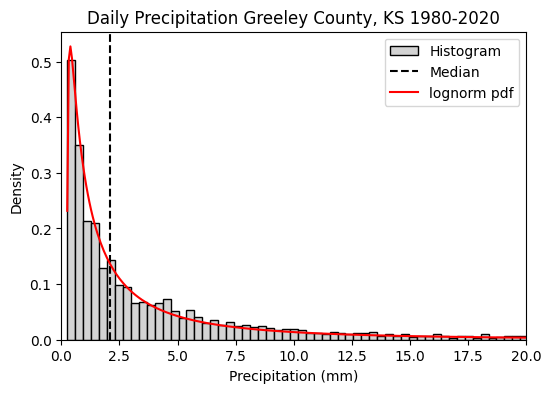

In [22]:
# Create vector from 0 to x_max to plot the lognorm pdf
x = np.linspace(data.min(), data.max(), num=1000)

# Create figure
plt.figure(figsize=(6,4))
plt.title('Daily Precipitation Greeley County, KS 1980-2020')
plt.hist(data, bins=200, density=True,
         facecolor='lightgrey', edgecolor='k', label='Histogram')
plt.axvline(median_rainfall, linestyle='--', color='k', label='Median')
plt.plot(x, stats.lognorm.pdf(x, *fitted_pdf.params), color='r', label='lognorm pdf')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Density')
plt.xlim([0, 20])
plt.legend()
plt.show()


## Cumulative density function

We can also ask: What is the probability of having a daily rainfall event equal or lower than `x` amount? The empirical cumulative dsitribution can help us answer this question. Note that if we ask `greater`  than `x` amount, we will need to use the complementary cumulative distribution function (basically `1-p`).

In [25]:
# Select rainfall events lower or equal than a specific amount
amount = 5

# Use actual data to estimate the probability
p = stats.lognorm.cdf(amount, *fitted_pdf.params)
print(f'The probability of having a rainfall event  <= {amount} mm is {p:.2f}')
print(f'The probability of having a rainfall event  > {amount} mm is {1-p:.2f}')

The probability of having a rainfall event  <= 5 mm is 0.75
The probability of having a rainfall event  > 5 mm is 0.25


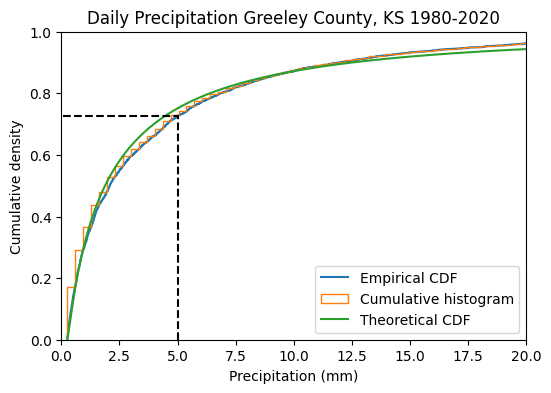

In [24]:
# Cumulative distributions
plt.figure(figsize=(6,4))
plt.ecdf(data, label="Empirical CDF")
plt.hist(data, bins=200, density=True, histtype="step",
         cumulative=True, label="Cumulative histogram")
plt.plot(x, stats.lognorm.cdf(x, *fitted_pdf.params), label='Theoretical CDF')

plt.plot([amount, amount, 0],[0, p, p], linestyle='--', color='k')
plt.title('Daily Precipitation Greeley County, KS 1980-2020')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Cumulative density')
plt.xlim([0, 20])
plt.legend()
plt.show()

In this tutorial we learned that:
- typical daily rainfall events in places like western Kansas tend to be very small, in the order of 2 mm. We found this by inspecting a histogram and computing the median of all days with measurable rainfall.

- the probability of having rainfall events larger than 5 mm is only 25%. We found this by using a cumulative density function. If we consider that rainfall interception by plant canopies and crop residue can range from 1 to several millimeters, daily rainfall events will be ineffective reaching the soil surface in regions with this type of daily rainfall distributions, where most of the soil water recharge will depend on larger rainfall events.

## References
Clark, O. R. (1940). Interception of rainfall by prairie grasses, weeds, and certain crop plants. Ecological monographs, 10(2), 243-277.

Dunkerley, D. (2000). Measuring interception loss and canopy storage in dryland vegetation: a brief review and evaluation of available research strategies. Hydrological Processes, 14(4), 669-678.

Kang, Y., Wang, Q. G., Liu, H. J., & Liu, P. S. (2004). Winter wheat canopy-interception with its influence factors under sprinkler irrigation. In 2004 ASAE Annual Meeting (p. 1). American Society of Agricultural and Biological Engineers.